# Country Pay Gap

In the [2018 Kaggle ML & DS Survey Challenge](https://www.kaggle.com/kaggle/kaggle-survey-2018/home) kagglers are asked to explore a dataset with survey results of themselves.
<br><br>
Among tens of multiple choice questions, the survey takers were asked to disclose a range of their yearly compensation, and about 2/3 respondents did.

In [340]:
import pandas as pd
import numpy as np

import operator

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df = pd.read_csv('multipleChoiceResponses.csv')
df.drop([0],inplace=True)

### ###
### DROP SOME DATA ###
# Start of time column
df['Time from Start to Finish (seconds)'] = df['Time from Start to Finish (seconds)'].apply(int)
# Rejecting those who answered questions too fast:
df = df[df['Time from Start to Finish (seconds)']>60]
# drop "Time" column
df.drop(['Time from Start to Finish (seconds)'],axis=1,inplace=True)
# End of time column
### ###

/sysroot/home/ekaterina/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,2,8,10,21,23,24,25,26,27,28,44,56,64,83,85,87,107,109,123,125,150,157,172,174,194,210,218,219,223,246,249,262,264,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,304,306,325,326,329,341,368,371,384,385,389,390,391,393,394) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [341]:
def is_salary_known(x):
    if (x=='I do not wish to disclose my approximate yearly compensation'): return 'unknown'
    if (x!=x): return 'unknown'
    return 'known'

df['is salary known']=df['Q9'].apply(lambda x: is_salary_known(x))

# all valid salary ranges:
all_salaries = ['0-10,000','10-20,000','20-30,000','30-40,000','40-50,000','50-60,000','60-70,000',
                       '70-80,000','80-90,000','90-100,000','100-125,000','125-150,000','150-200,000',
                       '200-250,000','250-300,000','300-400,000','400-500,000','500,000+']

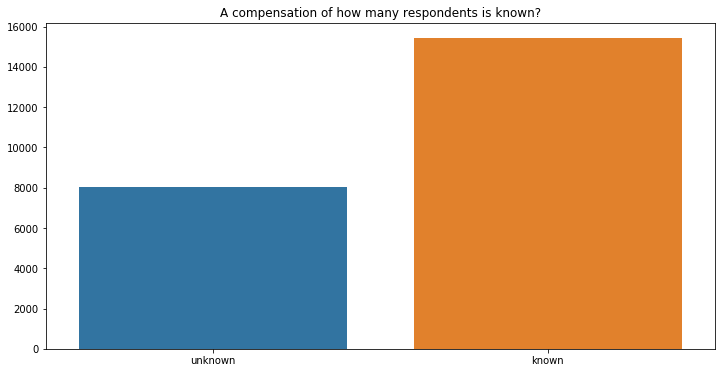

In [342]:
fig = plt.subplots(figsize=(12,6))
df_with_unknown_salaries = pd.DataFrame(df)
g1 = sns.countplot(x='is salary known',data=df_with_unknown_salaries, order=['unknown','known'])
g1.set_xlabel('')
g1.set_ylabel('')
out = g1.set_title('A compensation of how many respondents is known?')

_this study excludes respondents who spent less than a minute to complete the survey_
<br><br>
All possible yearly compensations are split into 18 ranges, from '0-10,000' to '500,000+':

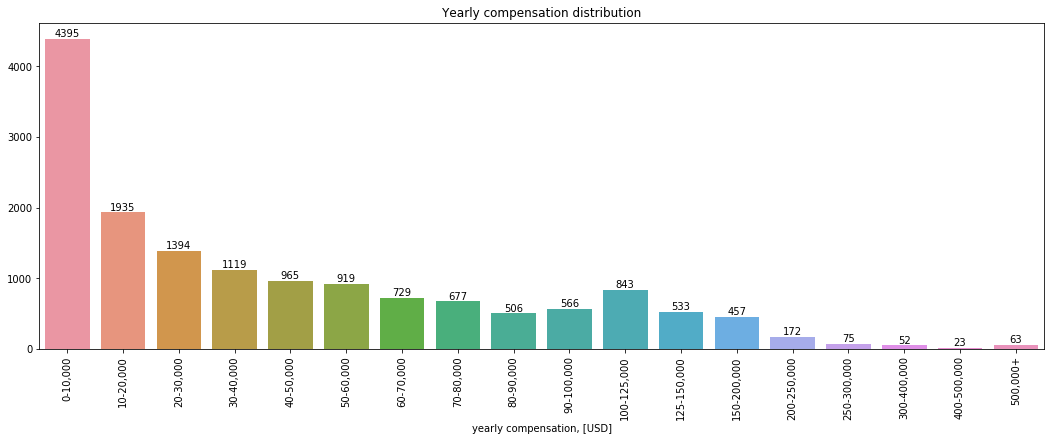

In [343]:
### ###
### DROP SOME DATA ###
# drop those who didn't disclose disclose their salary
# and those whose salary is unknown
df = df[(df['is salary known']=='known')]
### ###

# def: plot salary distribution
def plot_salary_distribution(df,col='Q9',x_label='yearly compensation, [USD]',order=None):
    fig, ax2 = plt.subplots(figsize=(18,6))
    g2 = sns.countplot(x=col,data=df, order=order, ax=ax2)
    g2.set_xticklabels(ax2.get_xticklabels(),rotation=90)
    g2.set_title('Yearly compensation distribution')
    g2.set_ylabel('')
    g2.set_xlabel(x_label)
    #ax2.set(yscale="log")
    for p in ax2.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax2.annotate(p.get_height(), (x.mean(), y), ha='center', va='bottom')
        
# plot salary distribution
plot_salary_distribution(df,order=all_salaries)

The peak around '100-125,000' corresponds to the average compensation of USA data scientists while the peak at '0-10,000' indicates a large representation of kagglers from countries with lower salary scales.
<br><br>

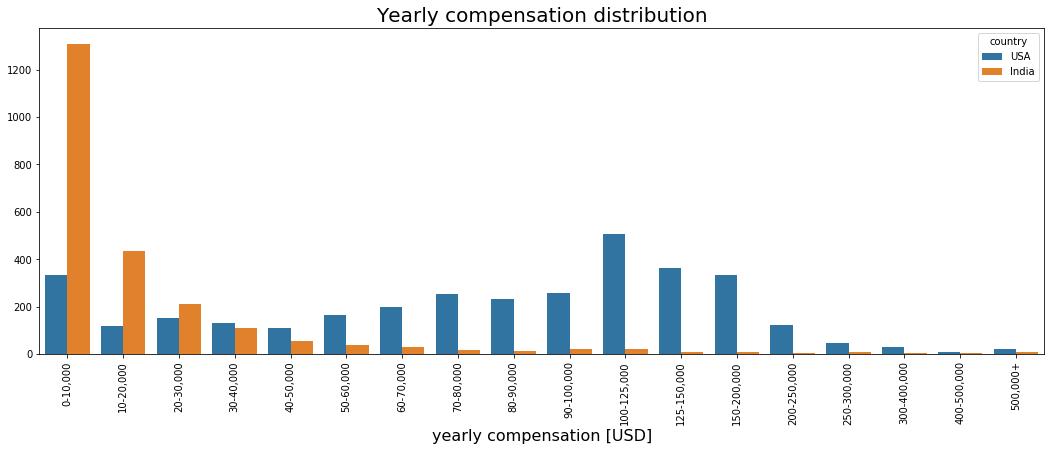

In [344]:
renamed_columns = {
    'Q1': 'gender',
    'Q2': 'age [years]',
    'Q3': 'country',
    'Q4': 'education',
    'Q5': 'undergraduate major',
    'Q6': 'job title',
    'Q7': 'industry',
    'Q8': 'experience in current role [years]',
    'Q9': 'yearly compensation [USD]',
    'Q10': 'Does your current employer use ML?',
    'Q24': 'experience writing data analysis code [years]',
    'Q25': 'experience using ML [years]'
}

def rename_columns(x):
    if x in renamed_columns.keys():
        return renamed_columns[x]
    return x

df.rename(columns=lambda x: rename_columns(x), inplace=True)


# shorten names of some countries
def rename_some_countries(x):
    if (x=='United States of America'): return 'USA'
    if (x=='United Kingdom of Great Britain and Northern Ireland'): return 'United Kingdom'
    if (x=='Iran, Islamic Republic of...'): return 'Iran'
    if (x=='Hong Kong (S.A.R.)'): return 'Hong Kong'
    return x

df['country']=df['country'].apply(lambda x: rename_some_countries(x))

# distribution over salary ranges
df_for_plot = df[(df['country']=='USA') | (df['country']=='India')]

fig, ax2 = plt.subplots(figsize=(18,6))
g2 = sns.countplot(x='yearly compensation [USD]',data=df_for_plot, 
                   order=all_salaries, ax=ax2, hue='country')
smth0 = g2.set_xticklabels(ax2.get_xticklabels(),rotation=90)
smth1 = g2.set_title('Yearly compensation distribution',fontsize=20)
smth2 = g2.set_ylabel('')
smth3 = g2.set_xlabel('yearly compensation [USD]',fontsize=16)

This kernel concentrates on the study of these discrepancies between compensations of kagglers residing in different countries which are refered as a __country pay gap__.

## Salary Quantification

The ranges are good for such comparison plots as one above and are distributed fairly well for USA, but for more in-depth compensation studies the ranges need to be quantified. It is essential to measure the difference in typical compensation for USA vs India, or between any other kaggler groups whether it is by an education, experience, main activities at work or a job title. 
<br><br>
Three quantification methods are used in this study:
- simple enumeration of compensation ranges<br>
    ('0-10,000' $\rightarrow$ 1, '10-20,000' $\rightarrow$ 2, '500,000+' $\rightarrow$ 18);
- averages of compensation range boundaties<br>
    ('0-10,000' $\rightarrow$ 5000, '10-20,000' $\rightarrow$ 15000, '500,000+' $\rightarrow$ 650000); and
- minimal values of range boundaries<br>
    ('0-10,000' $\rightarrow$ 0, '10-20,000' $\rightarrow$ 10000, '500,000+' $\rightarrow$ 500000)

In [345]:
# average salary values in each salary range
dict_averages = {'0-10,000':5000,'10-20,000':15000,'20-30,000':25000,
                '30-40,000':35000,'40-50,000':45000,'50-60,000':55000,
                '60-70,000':65000,'70-80,000':75000,'80-90,000':85000,
                '90-100,000':95000,'100-125,000':112500,'125-150,000':137500,
                '150-200,000':175000,'200-250,000':225000,'250-300,000':275000,
                '300-400,000':350000,'400-500,000':450000,'500,000+':650000}

dict_mins = {'0-10,000':0,'10-20,000':10000,'20-30,000':20000,
                 '30-40,000':30000,'40-50,000':40000,'50-60,000':50000,
                '60-70,000':60000,'70-80,000':70000,'80-90,000':80000,
                '90-100,000':90000,'100-125,000':100000,'125-150,000':125000,
                '150-200,000':150000,'200-250,000':200000,'250-300,000':250000,
                '300-400,000':300000,'400-500,000':400000,'500,000+':500000}

# quantify salary ranges by enumerating them
def quantify_enumerate(x):
    for i in range(1,len(all_salaries)+1):
        if (x==all_salaries[i-1]): return i
    return -100

# quantify salary ranges by getting an average for each range
def quantify_average(x):
    return dict_averages[x]

# quantify salary ranges by getting an average for each range
def quantify_min(x):
    return dict_mins[x]

df['enum salary ranges'] = df['yearly compensation [USD]'].apply(lambda x: quantify_enumerate(x))

df['salary averages'] = df['yearly compensation [USD]'].apply(lambda x: quantify_average(x))

df['salary mins'] = df['yearly compensation [USD]'].apply(lambda x: quantify_min(x))

# replace nans in all data with a string value
df.fillna('nan_value', inplace=True)

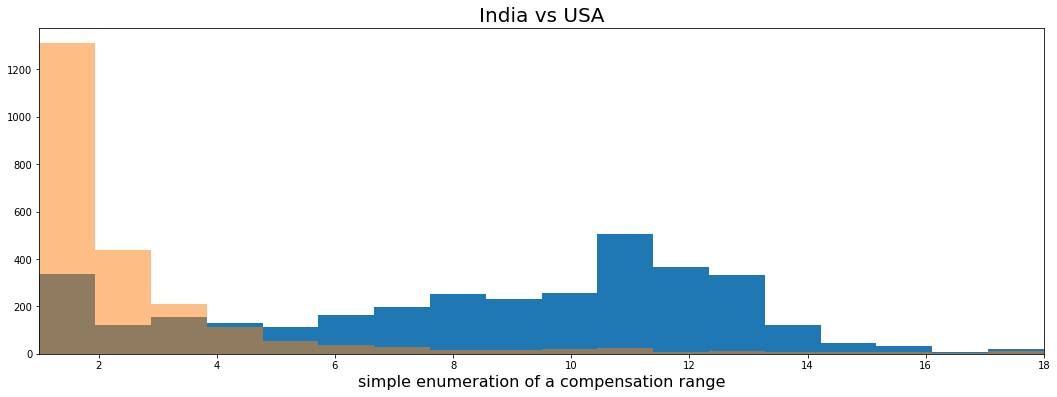

In [346]:
df_USA = pd.DataFrame(df[df['country']=='USA'])
df_India = pd.DataFrame(df[df['country']=='India'])

fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(111)
p1 = plt.hist(df_USA['enum salary ranges'],bins=18)
p2 = plt.hist(df_India['enum salary ranges'],bins=18,alpha=0.5)
p3 = plt.title('India vs USA',fontsize=20)
p4 = plt.xlabel('simple enumeration of a compensation range',fontsize=16)
p5 = plt.xlim(1,18)

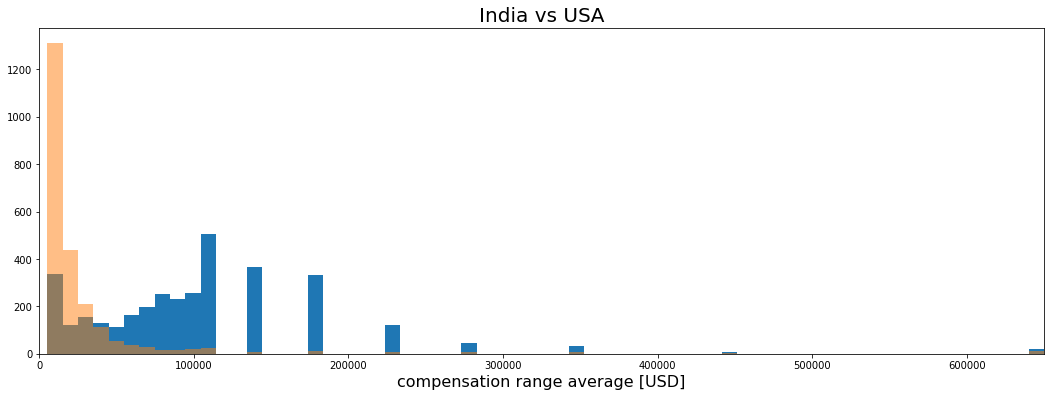

In [347]:
# salary averages
# the code to compute salary range averages is available above
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(111)
p1 = plt.hist(df_USA['salary averages'],bins=65)
p2 = plt.hist(df_India['salary averages'],bins=65,alpha=0.5)
p3 = plt.title('India vs USA',fontsize=20)
p4 = plt.xlabel('compensation range average [USD]',fontsize=16)
p5 = plt.xlim(0,650000)

In [348]:
# print out number of events in a given category
# and also mean and std salary
def print_mean_std_name_n(name,n,mean,std):
    print('{}: count={}, mean={},std={}'.
              format(name,n,int(mean),int(std),int(100*std/mean)))

# mean and std salary of all categories for a given df column
# df_col is usually a df[[col]] but could be an original df
def cats_mean_and_std(df_col,n_cut,salary_quantification_col):
    categories = df_col[col].unique()
    n_cats = categories.size
    dict_cats = {}
    for cat in categories:
        df_local = df_col[df_col[col]==cat]
        n = df_local.shape[0]
        if (n<n_cut): continue
        val_mean = df_local[salary_quantification_col].mean(axis=0)
        val_std = df_local[salary_quantification_col].std(axis=0)
        val_mean=int(val_mean)
        val_std=int(val_std)
        dict_cats[cat] = [val_mean, val_std]
    return dict_cats

# calculate separation of salary
# between two categories
# it's defined as |mean1-mean2|-sqrt(std1^2+std2^2)
# if it's bigger than zero, 
# the separation is significant
def separation(mean1,mean2,std1,std2):
    diff = abs(mean1-mean2)
    std = (std1**2+std2**2)**0.5
    return diff-std

# an array of all salary separations
# for all category pairs
def separations(dict_cats):
    n = len(dict_cats)
    keys = list(dict_cats.keys())
    seps = []
    sep_max = ['key1','key2',-100]
    for i in range(n):
        for j in range(i,n):
            key1 = keys[i]
            key2 = keys[j]
            mean1,std1 = dict_cats[key1]
            mean2,std2 = dict_cats[key2]
            sep = separation(mean1,mean2,std1,std2)
            if (sep>0): seps.append([key1,key2,int(sep)])
            if (sep>sep_max[2]): 
                sep_max[0] = key1
                sep_max[1] = key2
                sep_max[2] = int(sep)
    return sep_max,seps

In [349]:
cols_to_check = []
for col in df.columns:
    if (col=='yearly compensation [USD]'): continue
    if (col=='enum salary ranges'): continue
    if (col=='salary averages'): continue
    if (col=='salary mins'): continue
    if (col=='is salary known'): continue
    if (col=='N salary 0-10,000'): continue
    n = len(df[col].unique())
    if (n<100):
        cols_to_check.append(col)

## What Factors Affect Kaggler's Compensation the Most

In [350]:
# Salary separations
# Method 1
n_cut = 20
seps_max = []
salary_quantification_col='enum salary ranges'
for col in cols_to_check:
    df_col = df[[col,salary_quantification_col]]
    dict_cats = cats_mean_and_std(df_col,n_cut,salary_quantification_col)
    sep_max,seps = separations(dict_cats)
    if (len(seps)>0):
        #print(col, 'sep max =',sep_max)
        seps_max.append([col,sep_max[0],sep_max[1],sep_max[2]])
seps_max = sorted(seps_max, key = lambda x: int(x[3]))
print('')
print('The most significant factors affecting yearly compensation')
print('estimated besed on simple salary ranges enumeration:')
print('')
for i in range(len(seps_max)-1,-1,-1):
    print(seps_max[i][0], ':',seps_max[i][1],'vs',seps_max[i][2],'( score =',seps_max[i][3],')')


The most significant factors affecting yearly compensation
estimated besed on simple salary ranges enumeration:

experience writing data analysis code [years] : < 1 year vs 30-40 years ( score = 4 )
experience in current role [years] : nan_value vs 30 + ( score = 4 )
age [years] : 18-21 vs 55-59 ( score = 4 )
country : Norway vs Egypt ( score = 3 )
experience using ML [years] : I have never studied machine learning but plan to learn in the future vs 20+ years ( score = 2 )
job title : Student vs Principal Investigator ( score = 2 )
industry : I am a student vs Government/Public Service ( score = 1 )


In [351]:
# Salary separations
# Method 2
n_cut = 20
seps_max = []
salary_quantification_col='salary averages'
for col in cols_to_check:
    df_col = df[[col,salary_quantification_col]]
    dict_cats = cats_mean_and_std(df_col,n_cut,salary_quantification_col)
    sep_max,seps = separations(dict_cats)
    if (len(seps)>0):
        #print(col, 'sep max =',sep_max)
        seps_max.append([col,sep_max[0],sep_max[1],sep_max[2]])
seps_max = sorted(seps_max, key = lambda x: int(x[3]))
print('')
print('The most significant factors affecting yearly compensation')
print('estimated besed on salary range averages:')
print('')
for i in range(len(seps_max)-1,-1,-1):
    print(seps_max[i][0], ':',seps_max[i][1],'vs',seps_max[i][2],'( score =',seps_max[i][3],'USD)')


The most significant factors affecting yearly compensation
estimated besed on salary range averages:

country : Nigeria vs Norway ( score = 22297 USD)
experience in current role [years] : nan_value vs 20-25 ( score = 2223 USD)


Both methods found country of residence to be the most significant factor affecting a kaggler's yearly compensation.
<br><br>
Some other parameters like experience with data analysis and machine learning algorithms also affect one's compensation by factor of several but for a closer investigation we have to exclude one very important group of kagglers. 

ValueError: Could not interpret input 'is_student'

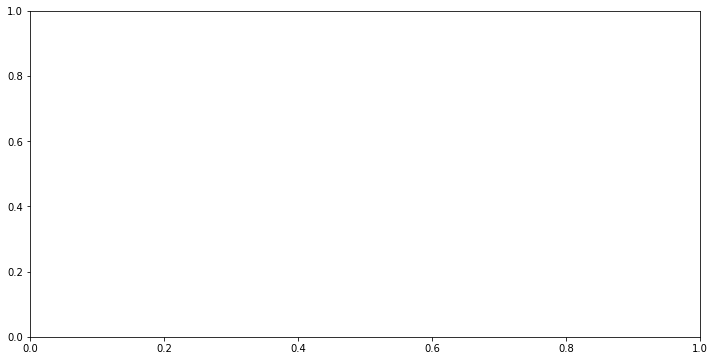

In [352]:
def is_student(x):
    if (x=='Student'): return 'Student'
    if (x=='I am a student'): return 'Student'
    return 'Not a student'

df_with_students = pd.DataFrame(df)

fig = plt.subplots(figsize=(12,6))
g1 = sns.countplot(x='is_student',data=df_with_students, order=['Student','Not a student'])
g1.set_xlabel('')
g1.set_ylabel('')
out = g1.set_title('Are you a student?')

In [286]:
def plot_one_count_and_box_plot(df,col,salary_quantification_col,y_label,order=None):
    if (col=='country'): # Q3 is country
        fig, (ax1,ax2) = plt.subplots(figsize=(18,28),ncols=2)
    else:
        fig, (ax1,ax2) = plt.subplots(figsize=(18,12),ncols=2)
    g1 = sns.boxplot(y=col,x=salary_quantification_col,data=df, ax=ax1,order=order)
    g2 = sns.countplot(y=col,data=df, ax=ax2,order=order)
    g1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
    g2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
    g1.set_xlabel(salary_quantification_col)
    g2.set_xlabel('counts')
    g1.set_title(y_label)
    g2.set_title('distribution of # of respondents by'+y_label)
    g1.set_ylabel('')
    g2.set_ylabel('')
    for p in ax2.patches:
        x=p.get_bbox().get_points()[:,1]
        y=p.get_bbox().get_points()[1,0]
        ax2.annotate(p.get_width(),(p.get_width()+2,p.get_y()+0.4))
    if (col=='country' or col=='job title' or col=='industry'):  
        ax2.set(xscale="log")
        g2.set_xticklabels(ax2.get_xticklabels(), rotation=90)

In [287]:
def values_by_salary_order(df,col,salary_quantification_col):
    d = df.groupby(by=col).mean().to_dict()[salary_quantification_col]
    sorted_d = sorted(d.items(), key=operator.itemgetter(1))
    countries_order = ['X']*len(sorted_d)
    for i in range(len(sorted_d)):
        countries_order[i]=sorted_d[i][0]
    return countries_order

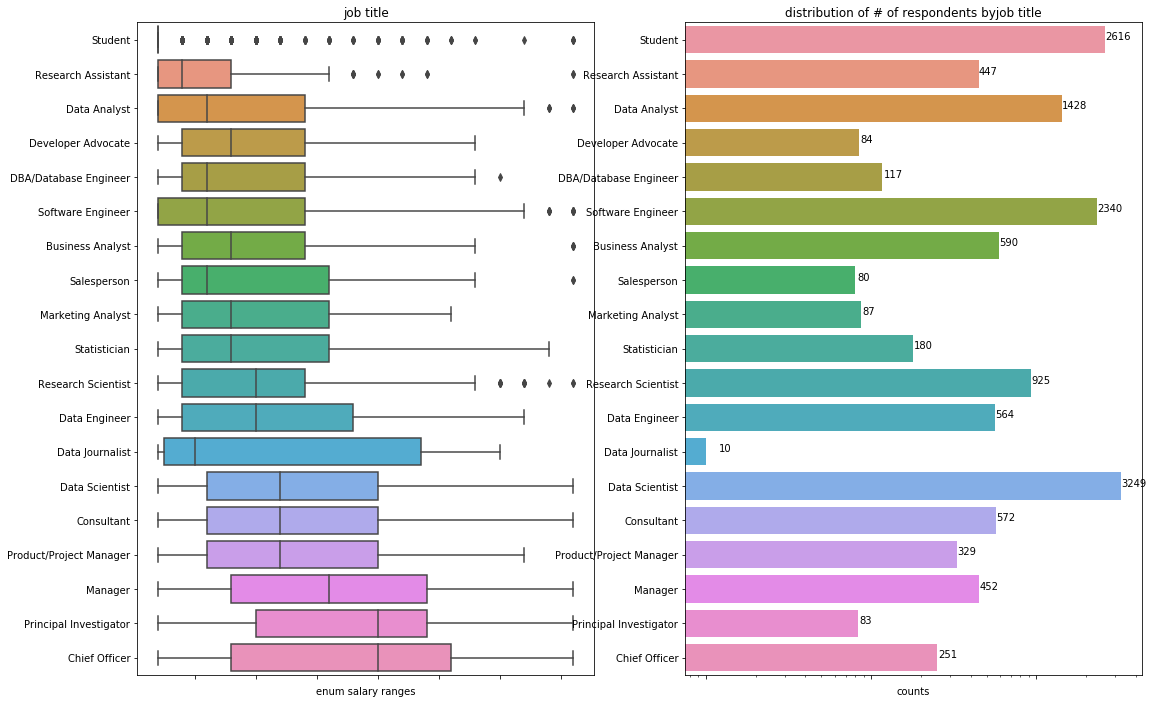

In [288]:
# Start with Q6
# Q6 - job title

salary_quantification_col = 'enum salary ranges'
df_title = df[['job title',salary_quantification_col]]
df_title = df_title[df_title['job title']!='Other']
order = values_by_salary_order(df_title,'job title',salary_quantification_col)
plot_one_count_and_box_plot(df_title,'job title',
                            salary_quantification_col,'job title',order)

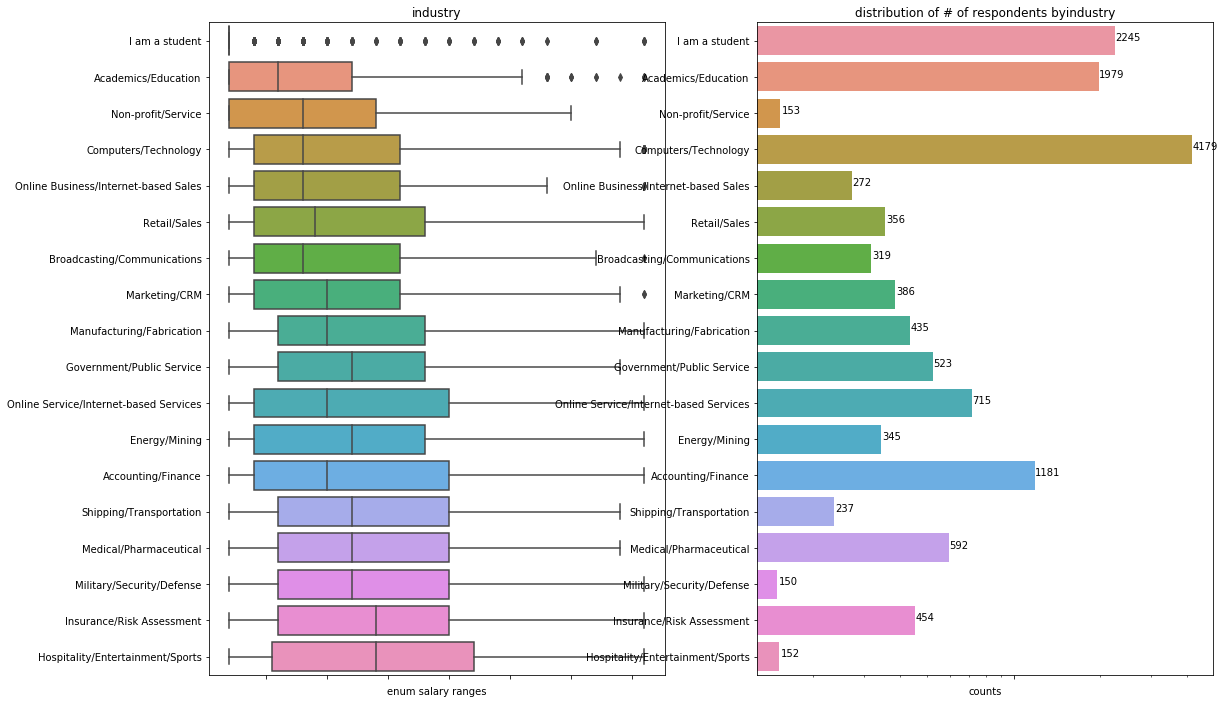

In [289]:
# Q7 - industry

salary_quantification_col = 'enum salary ranges'
df_industry = df[['industry',salary_quantification_col]]
df_industry = df_industry[df_industry['industry']!='Other']
order = values_by_salary_order(df_industry,'industry',salary_quantification_col)
plot_one_count_and_box_plot(df_industry,'industry',salary_quantification_col,'industry',order)

In [290]:
print('# of respondents before removing students: ',df.shape[0])
df['is_student'] = df['job title'].apply(lambda x: is_student(x))
df = df[df['is_student']!='Student']
df['is_student'] = df['industry'].apply(lambda x: is_student(x))
df = df[df['is_student']!='Student']
print('# of respondents after students: ',df.shape[0])

# of respondents before removing students:  15423
# of respondents after students:  12362


## What Factors Affect Kaggler's non-Student Compensation the Most

In [295]:
# Run the same separation checks but without students
# Salary separations
# Method 1
n_cut = 20
seps_max = []
salary_quantification_col='enum salary ranges'
for col in cols_to_check:
    df_col = df[[col,salary_quantification_col]]
    dict_cats = cats_mean_and_std(df_col,n_cut,salary_quantification_col)
    sep_max,seps = separations(dict_cats)
    if (len(seps)>0):
        #print(col, 'sep max =',sep_max)
        seps_max.append([col,sep_max[0],sep_max[1],sep_max[2]])
seps_max = sorted(seps_max, key = lambda x: int(x[3]))
print('')
print('The most significant factors affecting yearly compensation')
print('estimated besed on simple salary ranges enumeration:')
print('')
for i in range(len(seps_max)-1,-1,-1):
    print(seps_max[i][0], ':',seps_max[i][1],'vs',seps_max[i][2],'( score =',seps_max[i][3],')')

country : Switzerland vs Viet Nam ( 6 )
experience writing data analysis code [years] : I have never written code but I want to learn vs 30-40 years ( 3 )
age [years] : 18-21 vs 55-59 ( 3 )
Q35_Part_3 : 5 vs 75.0 ( 1 )
experience using ML [years] : I have never studied machine learning but plan to learn in the future vs 20+ years ( 1 )
job title : Research Assistant vs Principal Investigator ( 1 )
Q35_Part_4 : 5 vs 90.0 ( 0 )
Q34_Part_4 : 35 vs 1.0 ( 0 )
Q34_Part_3 : 25 vs 2.0 ( 0 )


In [296]:
# Salary separations
# Method 2
n_cut = 20
seps_max = []
salary_quantification_col='salary averages'
for col in cols_to_check:
    df_col = df[[col,salary_quantification_col]]
    dict_cats = cats_mean_and_std(df_col,n_cut,salary_quantification_col)
    sep_max,seps = separations(dict_cats)
    if (len(seps)>0):
        #print(col, 'sep max =',sep_max)
        seps_max.append([col,sep_max[0],sep_max[1],sep_max[2]])
seps_max = sorted(seps_max, key = lambda x: int(x[3]))
print('')
print('The most significant factors affecting yearly compensation')
print('estimated besed on salary range averages:')
print('')
for i in range(len(seps_max)-1,-1,-1):
    print(seps_max[i][0], ':',seps_max[i][1],'vs',seps_max[i][2],'( score =',seps_max[i][3],'USD)')

country : Switzerland vs Viet Nam ( 39137 USD)


For non-students respondents, country is the most significant factor to affect the compensation.

In [105]:
"""
# How many countries have >50% of data scientists making 0-10'000
dict_countries = dict(df['Q3'].value_counts())
i=1
print('More than 50% of respondents from these countries have')
print('a yearly compensation of less than $10K:')
print('')
for country in dict_countries.keys():
    ordered_dict = ranges_to_numerical(df[df['Q3']==country], col_name='Q9', whole_set = all_salaries)
    if ('0-10,000') in ordered_dict.keys():
        if (ordered_dict['0-10,000']>=50):
            print('{}. ({}%) {}'.format(i,int(ordered_dict['0-10,000']),country))
            i+=1

print('')
# How many countries have <5% of data scientists making 0-10'000
i=1
print('Less than 5% of respondents from these countries have')
print('a yearly compensation of less than $10K:')
print('')
for country in dict_countries.keys():
    ordered_dict = ranges_to_numerical(df[df['Q3']==country], col_name='Q9', whole_set = all_salaries)
    if ('0-10,000') in ordered_dict.keys():
        if (ordered_dict['0-10,000']<5):
            print('{}. ({}%) {}'.format(i,int(ordered_dict['0-10,000']),country))
            i+=1
"""

"\n# How many countries have >50% of data scientists making 0-10'000\ndict_countries = dict(df['Q3'].value_counts())\ni=1\nprint('More than 50% of respondents from these countries have')\nprint('a yearly compensation of less than $10K:')\nprint('')\nfor country in dict_countries.keys():\n    ordered_dict = ranges_to_numerical(df[df['Q3']==country], col_name='Q9', whole_set = all_salaries)\n    if ('0-10,000') in ordered_dict.keys():\n        if (ordered_dict['0-10,000']>=50):\n            print('{}. ({}%) {}'.format(i,int(ordered_dict['0-10,000']),country))\n            i+=1\n\nprint('')\n# How many countries have <5% of data scientists making 0-10'000\ni=1\nprint('Less than 5% of respondents from these countries have')\nprint('a yearly compensation of less than $10K:')\nprint('')\nfor country in dict_countries.keys():\n    ordered_dict = ranges_to_numerical(df[df['Q3']==country], col_name='Q9', whole_set = all_salaries)\n    if ('0-10,000') in ordered_dict.keys():\n        if (ordered

N of respondents:  12362
N of respondents from known countries:  11675
N of countries: 56
{'USA': 2820, 'India': 1664, 'Russia': 508, 'China': 471, 'Brazil': 443, 'United Kingdom': 437, 'Germany': 413, 'Canada': 363, 'France': 349, 'Japan': 339, 'Spain': 320, 'Italy': 205, 'Poland': 195, 'Australia': 195, 'Turkey': 171, 'Netherlands': 167, 'Ukraine': 147, 'Mexico': 139, 'Israel': 117, 'Singapore': 110, 'Sweden': 108, 'Switzerland': 93, 'Argentina': 91, 'Nigeria': 90, 'Colombia': 90, 'South Africa': 89, 'Portugal': 85, 'South Korea': 84, 'Indonesia': 81, 'Viet Nam': 79, 'Greece': 70, 'Pakistan': 69, 'Hungary': 65, 'Denmark': 63, 'Belgium': 62, 'Ireland': 59, 'Malaysia': 57, 'Chile': 52, 'Belarus': 52, 'Kenya': 48, 'Norway': 47, 'Finland': 46, 'Romania': 45, 'Czech Republic': 44, 'Peru': 44, 'New Zealand': 44, 'Thailand': 43, 'Philippines': 42, 'Iran': 39, 'Egypt': 39, 'Hong Kong': 37, 'Bangladesh': 36, 'Austria': 34, 'Republic of Korea': 31, 'Morocco': 25, 'Tunisia': 19}


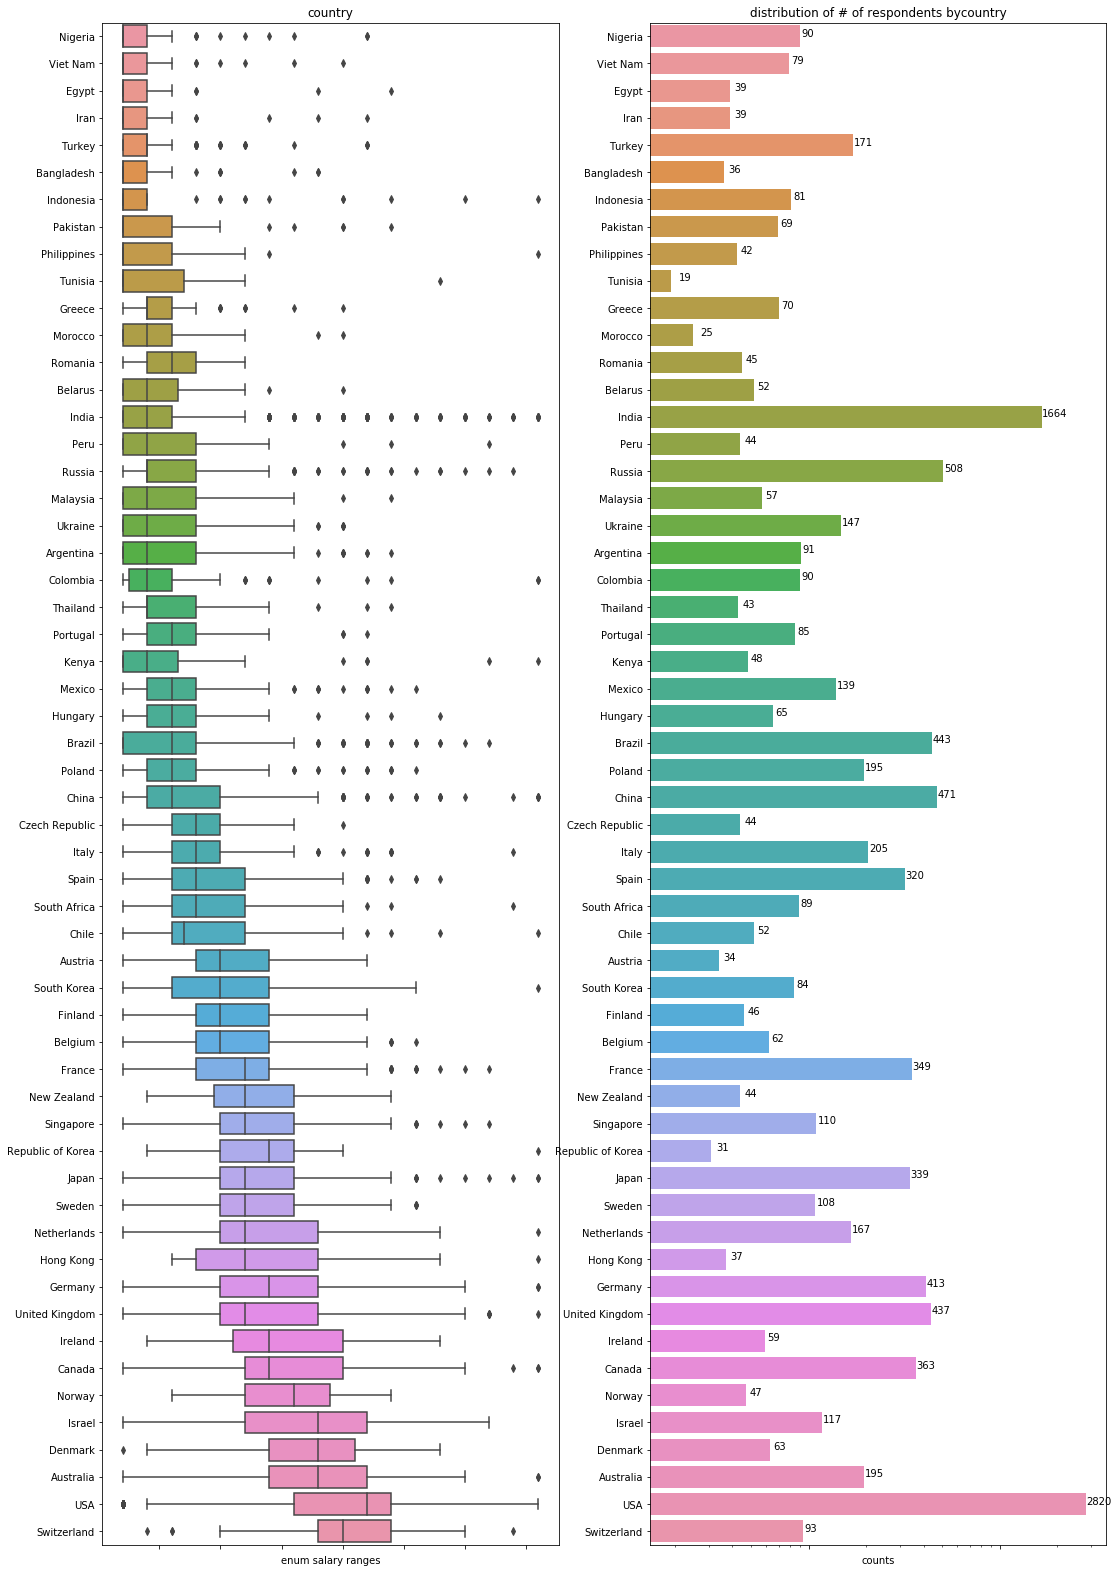

In [294]:
# Q3 - country
salary_quantification_col='enum salary ranges'

# shorten names of some countries
def rename_some_countries(x):
    if (x=='United States of America'): return 'USA'
    if (x=='United Kingdom of Great Britain and Northern Ireland'): return 'United Kingdom'
    if (x=='Iran, Islamic Republic of...'): return 'Iran'
    if (x=='Hong Kong (S.A.R.)'): return 'Hong Kong'
    return x

df['country']=df['country'].apply(lambda x: rename_some_countries(x))

df_countries = df[['country',salary_quantification_col]]
print('N of respondents: ',df_countries.shape[0])
df_countries = df_countries[df_countries['country']!='Other']
df_countries = df_countries[df_countries['country']!='I do not wish to disclose my location']
print('N of respondents from known countries: ',df_countries.shape[0])

n_countries = len(dict(df_countries['country'].value_counts()))
print('N of countries:',n_countries)

print(dict(df_countries['country'].value_counts()))

order = values_by_salary_order(df_countries,'country',salary_quantification_col)
plot_one_count_and_box_plot(df_countries,'country',salary_quantification_col,'country',order)

In [218]:
df_by_country.head()

,enum salary ranges,salary averages,country,"salary 0-10,000",N
country,,,,,
Argentina,3,26620,91,25,91
Australia,8,101269,195,5,195
Austria,5,49852,34,2,34
Bangladesh,2,17222,36,24,36
Belarus,2,22692,52,14,52


Some additional data
- [average income](https://www.worlddata.info/average-income.php)
- [cost index](https://www.numbeo.com/cost-of-living/rankings_by_country.jsp)
- [population](http://www.worldometers.info/world-population/population-by-country/)

In [256]:
# [average_income, cost_index, population(millions)]
# average income: https://www.worlddata.info/average-income.php
# https://www.numbeo.com/cost-of-living/rankings_by_country.jsp
# http://www.worldometers.info/world-population/population-by-country/
dict_countries_additional_info = {
    'USA': [58270, 68.95, 327], 
    'India': [1820, 23.81, 1354], 
    'Russia': [9230, 36.73, 144], 
    'China': [8690, 40.43, 1415], 
    'Brazil': [8580, 40.48, 211], 
    'United Kingdom': [40530, 67.18, 67], 
    'Germany': [43490, 67.89, 82], 
    'Canada': [42870, 64.54, 37], 
    'France': [37970, 74.83, 65], 
    'Japan': [38550, 79.87, 127], 
    'Spain': [27180, 55.43, 46], 
    'Italy': [31020, 69.68, 59], 
    'Poland': [12710, 38.69, 38], 
    'Australia': [51360, 73.87, 25], 
    'Turkey': [10930, 35.52, 82], 
    'Netherlands': [46180, 75.93, 17], 
    'Ukraine': [2390, 27.08, 44]
}
"""
    'Mexico': [], 
    'Israel': [], 
    'Singapore': [], 
    'Sweden': [], 
    'Switzerland': [], 
    'Argentina': [], 
    'Nigeria': [], 
    'Colombia': [], 
    'South Africa': [], 
    'Portugal': [], 
    'South Korea': [], 
    'Indonesia': [], 
    'Viet Nam': [], 
    'Greece': [], 
    'Pakistan': [], 
    'Hungary': [], 
    'Denmark': [], 
    'Belgium': [], 
    'Ireland': [], 
    'Malaysia': [], 
    'Chile': [], 
    'Belarus': [], 
    'Kenya': [], 
    'Norway': [], 
    'Finland': [], 
    'Romania': [], 
    'Czech Republic': [], 
    'Peru': [], 
    'New Zealand': [], 
    'Thailand': [], 
    'Philippines': [], 
    'Iran': [], 
    'Egypt': [], 
    'Hong Kong': [], 
    'Bangladesh': [], 
    'Austria': [], 
    'Republic of Korea': [], 
    'Morocco': [], 
    'Tunisia': []
    """

df_add_info = pd.DataFrame(dict_countries_additional_info)
df_add_info = df_add_info.transpose()
df_add_info.rename(columns={0:'country average income',1:'cost of living index',2:'population'},
                  inplace=True)

In [297]:
def is_lowest_range(x):
    if (x=='0-10,000'): return 1
    return 0
df['N salary 0-10,000'] = df['yearly compensation [USD]'].apply(lambda x: is_lowest_range(x))
df_by_country = df.groupby(by='country').agg({
    'enum salary ranges': 'mean',
    'salary averages': 'mean',
    'salary mins': 'mean',
    'country':'count',
    'N salary 0-10,000': 'sum'
})

df_by_country['N respondents'] = df_by_country['country']
df_by_country.drop('country',axis=1,inplace=True)

df_by_country.drop('Other',axis=0,inplace=True)
df_by_country.drop('I do not wish to disclose my location',axis=0,inplace=True)
df_by_country['salary averages']=df_by_country['salary averages'].apply(int)
df_by_country['salary mins']=df_by_country['salary mins'].apply(int)
df_by_country['enum salary ranges']=df_by_country['enum salary ranges'].apply(int)

df_by_country=df_by_country.join(df_add_info)
df_by_country.dropna(inplace=True)
df_by_country['country average income']=df_by_country['country average income'].apply(int)
df_by_country['population']=df_by_country['population'].apply(int)
df_by_country

,enum salary ranges,salary averages,salary mins,"N salary 0-10,000",N respondents,country average income,cost of living index,population
country,,,,,,,,
Australia,8,101269,90435,5,195,51360,73.87,25
Brazil,3,31783,26173,118,443,8580,40.48,211
Canada,7,80055,72038,8,363,42870,64.54,37
China,3,38476,31656,117,471,8690,40.43,1415
France,5,56790,50888,10,349,37970,74.83,65
Germany,6,68698,62033,9,413,43490,67.89,82
India,2,27943,21583,708,1664,1820,23.81,1354
Italy,4,42390,36804,9,205,31020,69.68,59
Japan,6,67558,60442,11,339,38550,79.87,127


In [298]:
def N_responders_per_million(row):
    return row['N respondents']/row['population']

def kaggler_salary_over_country_average(row):
    return row['salary averages']/row['country average income']

def kaggler_min_salary_over_country_average(row):
    return row['salary mins']/row['country average income']

def kaggler_salary_over_cost_index(row):
    return row['salary averages']/row['cost of living index']

def fraction_below_10000(row):
    return 100*row['N salary 0-10,000']/row['N respondents']

In [301]:
df_by_country['N responders per million of population'] = df_by_country.apply(lambda row: N_responders_per_million(row),axis=1)
df_by_country['N responders per million of population'] = df_by_country['N responders per million of population'].apply(lambda x: 
                                                                                                                        round(x,2))
df_by_country['kaggler salary over country average'] = df_by_country.apply(lambda row:
                                                                            kaggler_salary_over_country_average(row),axis=1)
df_by_country['kaggler salary over country average'] = df_by_country['kaggler salary over country average'].apply(lambda x: 
                                                                                                                    round(x,2))
df_by_country['kaggler salary over country average low estimate'] = df_by_country.apply(lambda row:
                                                                            kaggler_min_salary_over_country_average(row),axis=1)
df_by_country['kaggler salary over country average low estimate'] = df_by_country['kaggler salary over country average low estimate'].apply(lambda x: 
                                                                                                                    round(x,2))
df_by_country['kaggler salary over cost index'] = df_by_country.apply(lambda row:
                                                                            kaggler_salary_over_cost_index(row),axis=1)
df_by_country['kaggler salary over cost index'] = df_by_country['kaggler salary over cost index'].apply(int)
df_by_country['% with salary 0-10,000'] = df_by_country.apply(lambda row: fraction_below_10000(row),axis=1)
df_by_country['% with salary 0-10,000'] = df_by_country['% with salary 0-10,000'].apply(int)

In [302]:
df_by_country

,enum salary ranges,salary averages,salary mins,"N salary 0-10,000",N respondents,country average income,cost of living index,population,N responders per million of population,kaggler salary over country average,kaggler salary over country average low estimate,kaggler salary over cost index,"% with salary 0-10,000"
country,,,,,,,,,,,,,
Australia,8,101269,90435,5,195,51360,73.87,25,7.80,1.97,1.76,1370,2
Brazil,3,31783,26173,118,443,8580,40.48,211,2.10,3.70,3.05,785,26
Canada,7,80055,72038,8,363,42870,64.54,37,9.81,1.87,1.68,1240,2
China,3,38476,31656,117,471,8690,40.43,1415,0.33,4.43,3.64,951,24
France,5,56790,50888,10,349,37970,74.83,65,5.37,1.50,1.34,758,2
Germany,6,68698,62033,9,413,43490,67.89,82,5.04,1.58,1.43,1011,2
India,2,27943,21583,708,1664,1820,23.81,1354,1.23,15.35,11.86,1173,42
Italy,4,42390,36804,9,205,31020,69.68,59,3.47,1.37,1.19,608,4
Japan,6,67558,60442,11,339,38550,79.87,127,2.67,1.75,1.57,845,3


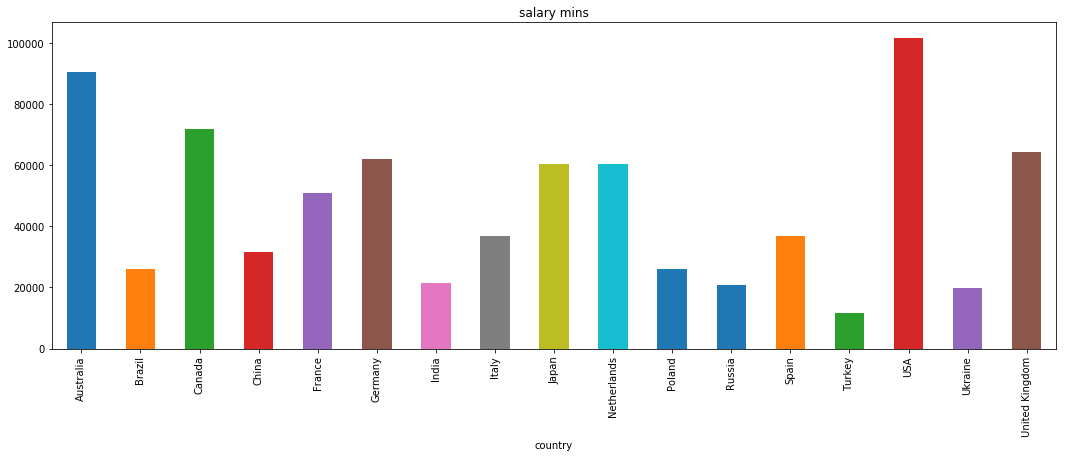

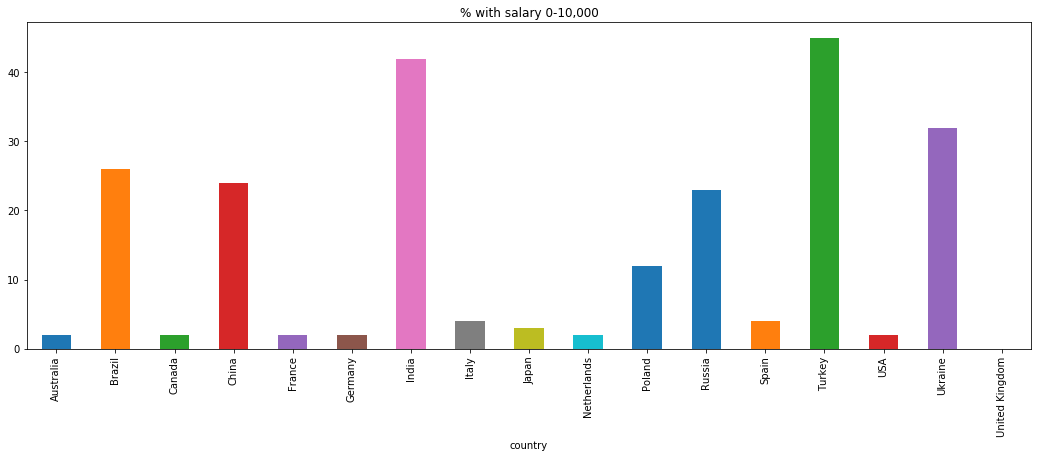

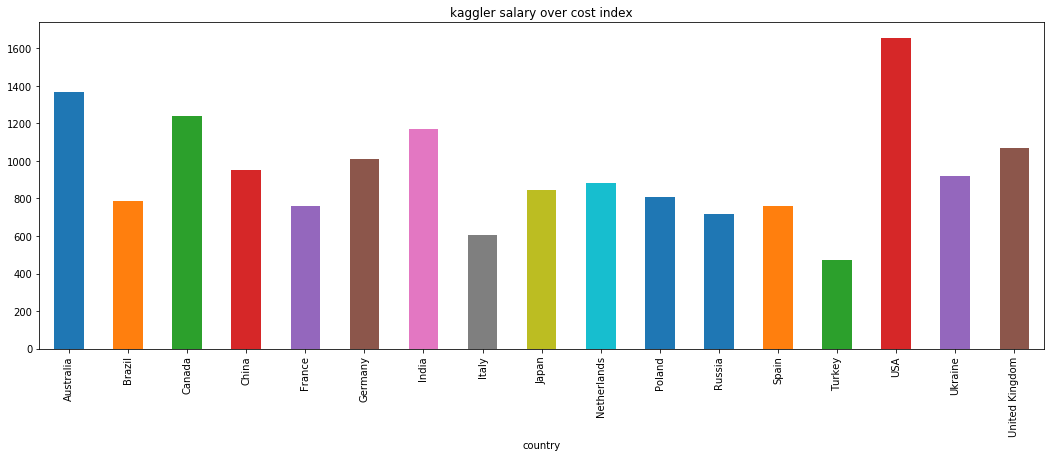

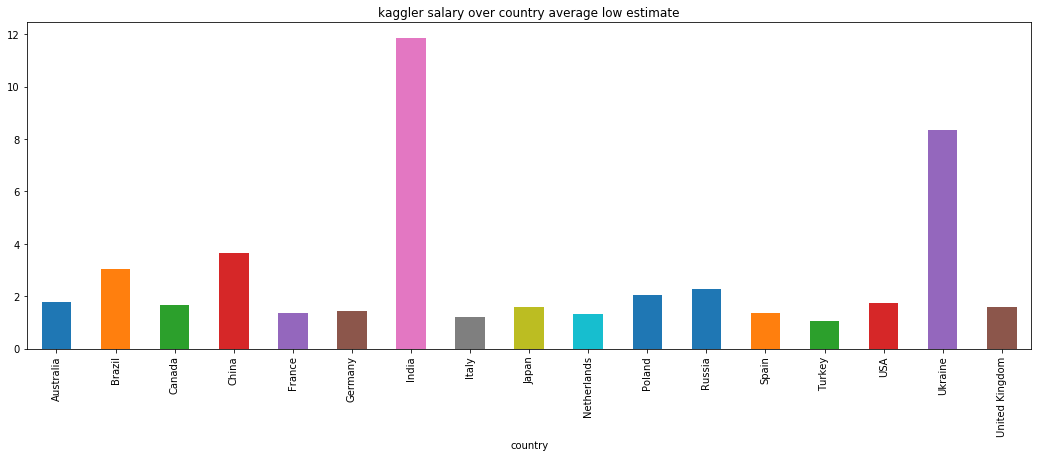

In [322]:
cols_to_plot=['salary mins', '% with salary 0-10,000',
              'kaggler salary over cost index','kaggler salary over country average low estimate']
for col in cols_to_plot:
    fig, ax2 = plt.subplots(figsize=(18,6))
    ax2.set_title(col)
    out = df_by_country[col].plot.bar()

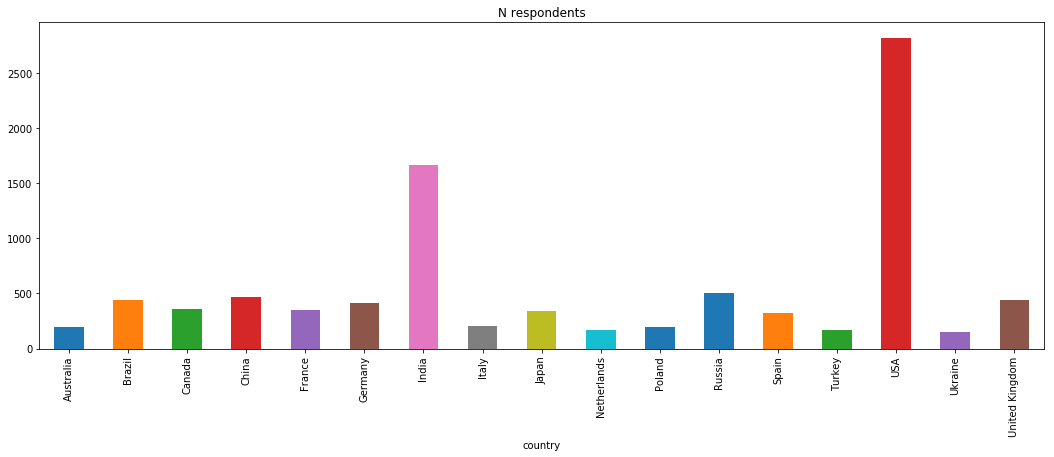

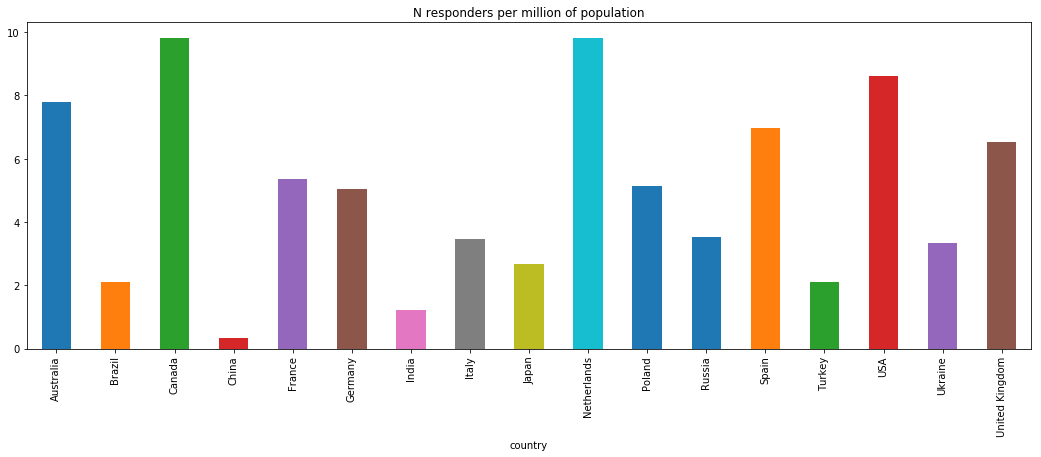

In [321]:
cols_to_plot=['N respondents', 'N responders per million of population']
for col in cols_to_plot:
    fig, ax2 = plt.subplots(figsize=(18,6))
    ax2.set_title(col)
    out = df_by_country[col].plot.bar()